# transformation-fits

In [1]:
import numpy as np
import xarray as xr

ds_trans = xr.open_zarr("/work/n01/n01/fwg/irminger-proj/data/processed/transformation-calculations.zarr")
ds_trans = ds_trans.squeeze()
ds_trans.load()

<xarray.Dataset>
Dimensions:           (classs: 131, run: 37)
Coordinates:
    XC                float32 12.5
  * classs            (classs) int64 0 1 2 3 4 5 6 ... 125 126 127 128 129 130
    iter              int64 901800
  * run               (run) int64 0 6 7 8 9 11 12 13 ... 41 42 43 44 46 47 48 49
    tau_int           (run) float64 0.0 -0.2611 -0.5222 ... -4.7 -7.014 -9.064
    time              timedelta64[ns] 20 days 21:00:00
Data variables:
    delta_MLD         (run) float32 -3.365 -22.73 -34.53 ... -119.0 -158.7
    rho_intermediate  (classs) float64 513.4 1.027e+03 ... 1.027e+03 inf
    rho_lower         (classs) float64 1.027e+03 1.027e+03 ... 1.027e+03 inf
    rho_upper         (classs) float64 0.0 1.027e+03 ... 1.027e+03 1.027e+03
    transformation    (run, classs) float32 -0.0 -0.0 ... 4.542e-06 4.542e-06

## Mixed layer depth
We propose that mixed layer depth change obeys the relation
$$\ln\Delta = \beta \ln\tau + \alpha
$$


In [34]:
y = np.log(-ds_trans["delta_MLD"]).squeeze().isel(run=slice(1, None))
x = np.log(-ds_trans["tau_int"]).isel(run=slice(1, None))

/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [35]:
def prob_of_measurement(alpha, beta, x_i, y_i):
    y_i_est = alpha + beta * x_i
    
    p = 1 / np.sqrt(2 * np.pi) * \
        np.exp(-np.square(y_i - y_i_est) * 0.5)
    
    return p

def log_likelihood(params):
    alpha, beta = params
    L = 0
    for x_i, y_i in zip(x.values, y.values):
        L += np.log(prob_of_measurement(alpha, beta, x_i, y_i))
    L *= -1
    return L


In [36]:
from scipy.optimize import minimize

In [37]:
minimize(log_likelihood, x0=(1, 1))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 33.26920390792921
        x: [ 3.869e+00  5.368e-01]
      nit: 4
      jac: [ 9.537e-07  4.768e-07]
 hess_inv: [[ 5.658e-02 -3.334e-02]
            [-3.334e-02  3.860e-02]]
     nfev: 18
     njev: 6

In [38]:
np.log(1) - np.log(0.95)

0.05129329438755058

In [39]:
from scipy.stats import linregress

In [40]:
regression_model = linregress(x, y)
regression_model

LinregressResult(slope=0.5367987297208525, intercept=3.8694649367495475, rvalue=0.9758006270675864, pvalue=4.9584479629885245e-24, stderr=0.020629302477140114, intercept_stderr=0.024974457931755442)

In [41]:
regression_model.stderr

0.020629302477140114

In [42]:
from scipy.stats import t

In [43]:
n = len(x)
error = t.ppf(0.975, n - 2) * regression_model.stderr

In [44]:
error

0.0419237866902224

In [45]:
print(regression_model.slope - error, regression_model.slope + error)

0.4948749430306301 0.578722516411075


In [46]:
regression_model.rvalue ** 2

0.9521868637854949

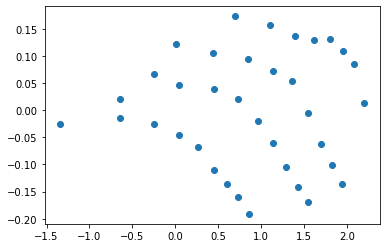

In [47]:
residual = y - x * regression_model.slope - regression_model.intercept

import matplotlib.pyplot as plt
plt.scatter(x, residual)

## Maximum transformation

In [56]:
y = ds_trans["transformation"].max(dim="classs")
x = -ds_trans["tau_int"]

regression_model = linregress(x, y)

n = len(x)
error = t.ppf(0.975, n - 2) * regression_model.stderr
print(
    regression_model.slope - error, 
    regression_model.slope,
    regression_model.slope + error,
)

error

0.000283703286271324 0.0003004773831933239 0.00031725148011532386


1.677409692199996e-05

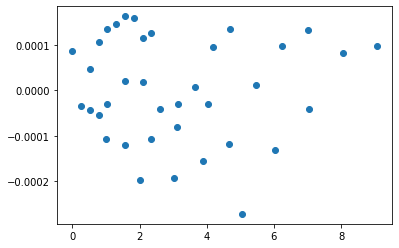

In [25]:
residual = y - x * regression_model.slope - regression_model.intercept

import matplotlib.pyplot as plt
plt.scatter(x, residual)

## Minimum transformation

In [55]:
y = ds_trans["transformation"].min(dim="classs")
x = -ds_trans["tau_int"]

regression_model = linregress(x, y)

n = len(x)
error = t.ppf(0.975, n - 2) * regression_model.stderr
print(
    regression_model.slope - error, 
    regression_model.slope,
    regression_model.slope + error,
)

error

-0.0002775059310331279 -0.00026909605732125183 -0.00026068618360937574


8.409873711876098e-06

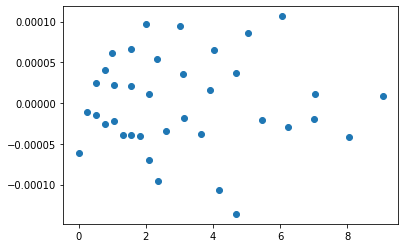

In [54]:
residual = y - x * regression_model.slope - regression_model.intercept

import matplotlib.pyplot as plt
plt.scatter(x, residual)

In [52]:
x

<xarray.DataArray 'tau_int' (run: 37)>
array([-0.        ,  0.26110711,  0.52220029,  0.77931836,  1.00711223,
        0.52221422,  1.04440057,  1.55863672,  2.01422446,  0.78332134,
        1.56660086,  2.33795508,  3.02133669,  1.04442845,  2.08880114,
        3.11727344,  4.02844892,  1.30553556,  2.61100143,  3.8965918 ,
        5.03556115,  1.56664267,  3.13320171,  4.67591016,  6.04267338,
        1.82774978,  3.655402  ,  5.45522852,  7.04978561,  2.0888569 ,
        4.17760228,  6.23454688,  8.05689784,  2.34996401,  4.69980257,
        7.01386524,  9.06401007])
Coordinates:
    XC       float32 12.5
    iter     int64 901800
  * run      (run) int64 0 6 7 8 9 11 12 13 14 16 ... 39 41 42 43 44 46 47 48 49
    tau_int  (run) float64 0.0 -0.2611 -0.5222 -0.7793 ... -4.7 -7.014 -9.064
    time     timedelta64[ns] 20 days 21:00:00